# German License Plate Recognition - Workflow
    

In [1]:
import os
import skimage
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path
import random
import re
import time
import cv2
import requests
import pandas as pd
import progressbar
import tarfile
import tensorflow as tf
import zipfile
import matplotlib

from distutils.version import StrictVersion
from imutils import paths
from PIL import Image

In [2]:
print ("Tensorflow: {}".format(tf.__version__))

if StrictVersion(tf.__version__.split('-')[0]) < StrictVersion('2.0.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v2.0.0')

if StrictVersion(tf.__version__.split('-')[0]) >= StrictVersion('3.0.0'):
    raise ImportError('Please downgrade your TensorFlow installation to v2.0.*.')

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

Tensorflow: 2.0.0
GPU device: /device:GPU:0


In [3]:
from config.license_recognition import config

DETECTION_MODEL_NAME = 'glpd-model.tflite'
RECOGNITION_MODEL_NAME = 'glpr-model.tflite'

OUTPUT_DIR = 'output'
DETECTION_MODEL_PATH = os.path.join(OUTPUT_DIR, 'plate_detection', DETECTION_MODEL_NAME)
RECOGNITION_MODEL_PATH = os.path.join(OUTPUT_DIR, 'license_recognition', RECOGNITION_MODEL_NAME)
TEST_IMAGES = 'data/license_recognition/test_images'

print("Output Directory:       {}".format(OUTPUT_DIR))
print("Detection Model Path:   {}".format(DETECTION_MODEL_PATH))
print("Recognition Model Path: {}".format(RECOGNITION_MODEL_PATH))
print("Test Images Path:       {}".format(TEST_IMAGES))

Output Directory:       output
Detection Model Path:   output\plate_detection\glpd-model.tflite
Recognition Model Path: output\license_recognition\glpr-model.tflite
Test Images Path:       data/license_recognition/test_images


# Workflow

In [4]:
# number of samples to test; -1 <=> all
NUM_SAMPLES = -1

PATH_TO_TEST_IMAGES_DIR = 'data/plate_detection/test_images'

In [5]:
import glob

TEST_IMAGE_PATHS = []
for filename in glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg')):
    TEST_IMAGE_PATHS.append(filename)
    
print ('Test images:')

if NUM_SAMPLES > 0:
    test_images = np.random.choice(TEST_IMAGE_PATHS, size = NUM_SAMPLES, replace=False)
else:
    test_images = TEST_IMAGE_PATHS

print (test_images)

Test images:
['data/plate_detection/test_images\\A-I999.jpg', 'data/plate_detection/test_images\\imagesAPVCN8QZ.jpg', 'data/plate_detection/test_images\\imagesDXUD3EJG.jpg', 'data/plate_detection/test_images\\imagesHD8QRDNI.jpg', 'data/plate_detection/test_images\\imagesHZF57N50.jpg', 'data/plate_detection/test_images\\imagesTHWV8H2K.jpg']


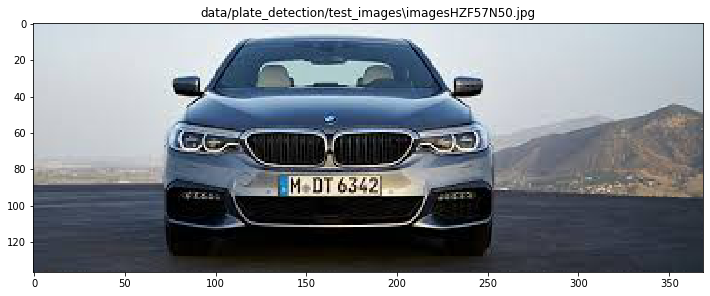

In [6]:
IMG_INDEX = 4

image_path = TEST_IMAGE_PATHS[IMG_INDEX]

plt.figure(figsize=(12, 12))
plt.title(image_path)
plt.imshow(Image.open(image_path))
plt.show()

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

Box: [0.59750074 0.3605353  0.70038813 0.5312686 ]
Class: 0
Score: 0.9972907304763794
Detections: 1


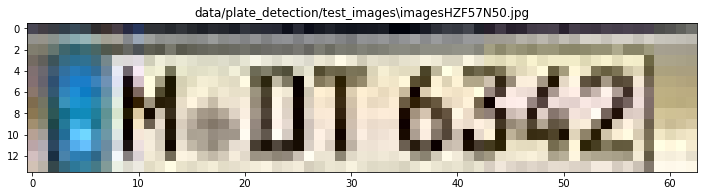

In [12]:
from tensorflow_core.lite.python.interpreter import Interpreter
from object_detection.utils import visualization_utils as vis_util
from PIL import ImageOps

%matplotlib inline 

input_mean = 127.5
input_std = 127.5

interpreter = Interpreter(model_path=DETECTION_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

image = Image.open(image_path)
image_np = load_image_into_numpy_array(image.resize((300, 300), Image.ANTIALIAS))
input_data = np.array(np.expand_dims(image_np, axis=0), dtype=np.float32)
input_data = (np.float32(input_data) - input_mean) / input_std

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

detection_box = np.squeeze(interpreter.tensor(output_details[0]['index'])())
print("Box: {}".format(detection_box))

detection_class = np.squeeze(interpreter.tensor(output_details[1]['index'])()).astype(np.uint8)
print("Class: {}".format(detection_class))

detection_score = np.squeeze(interpreter.tensor(output_details[2]['index'])())
print("Score: {}".format(detection_score))

num_detections = np.squeeze(interpreter.tensor(output_details[3]['index'])()).astype(int)
print("Detections: {}".format(num_detections))

if num_detections > 0 and detection_score > 0.9: 
    image_np = load_image_into_numpy_array(image)
    ymin, xmin, ymax, xmax = detection_box

    #vis_util.draw_bounding_box_on_image_array(image_np, ymin, xmin, ymax, xmax, color='red', thickness=1)            
    
    x1 = int(xmin * image_np.shape[1])
    x2 = int(xmax * image_np.shape[1])
    y1 = int(ymin * image_np.shape[0])
    y2 = int(ymax * image_np.shape[0])

    plate_img = image_np[y1:y2, x1:x2]

    plt.figure(figsize=(12, 12))
    plt.title(image_path)
    plt.imshow(plate_img)
    plt.show()

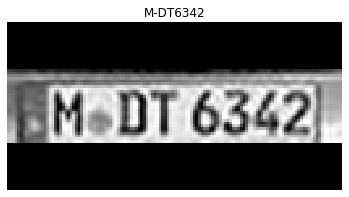

In [11]:
from tensorflow_core.lite.python.interpreter import Interpreter
from config.license_recognition import config
from label_codec import LabelCodec
from utils.preprocessing import AspectAwarePreprocessor

preprocessor = AspectAwarePreprocessor(config.IMAGE_WIDTH, config.IMAGE_HEIGHT)

image = preprocessor.preprocess(Image.fromarray(plate_img))
image = image.astype(np.float32) / 255.
image = np.expand_dims(image.T, axis=-1)

interpreter = Interpreter(model_path=RECOGNITION_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

interpreter.set_tensor(input_details[0]['index'], np.asarray([image]))
interpreter.invoke()
predictions = interpreter.get_tensor(output_details[0]['index'])

label = LabelCodec.decode_prediction(predictions[0])

plt.axis("off")
plt.title(label)
plt.imshow(image[:, :, 0].T, cmap='gray')
plt.show()